In [93]:
from itertools import permutations
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap as lsc
# from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import os
import pandas as pd
import pickle
import plotly.express as px
import random
import seaborn as sns
import sys
import scikit_posthocs as sp
import scipy.stats as stats
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor as rfr
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from statsmodels.formula.api import ols


In [2]:
products_df = pd.DataFrame()

if not os.path.isfile("products_df5.ftr"):
    # exit() crashes kernel
    sys.exit(
        'The file "products_df5.ftr" was not found! Please run "Hermel_Gabriel_1_notebook_nettoyage_092022.ipynb" in the same directory first.'
    )
else:
    products_df = pd.read_feather("products_df5.ftr")


In [23]:
products_df_sel_categ = products_df.loc[products_df["select_category"].notnull()]
products_df_sel_categ.reset_index(drop=True, inplace=True)
products_df_sel_categ = products_df_sel_categ.dropna(
    axis=1, thresh=products_df_sel_categ.shape[0] * 0.2
)
products_df_sel_categ.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 298110 entries, 0 to 298109
Data columns (total 68 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   code                      298110 non-null  object 
 1   product_name              296922 non-null  object 
 2   brands                    216994 non-null  object 
 3   primary_category          298110 non-null  object 
 4   secondary_category        298110 non-null  object 
 5   tertiary_category         298110 non-null  object 
 6   select_category           298110 non-null  object 
 7   energy-kcal_100g          298110 non-null  float64
 8   proteins_100g             298110 non-null  float64
 9   carbohydrates_100g        298110 non-null  float64
 10  sugars_100g               295593 non-null  float64
 11  fat_100g                  298110 non-null  float64
 12  saturated-fat_100g        290445 non-null  float64
 13  monounsaturated-fat_100g  173882 non-null  f

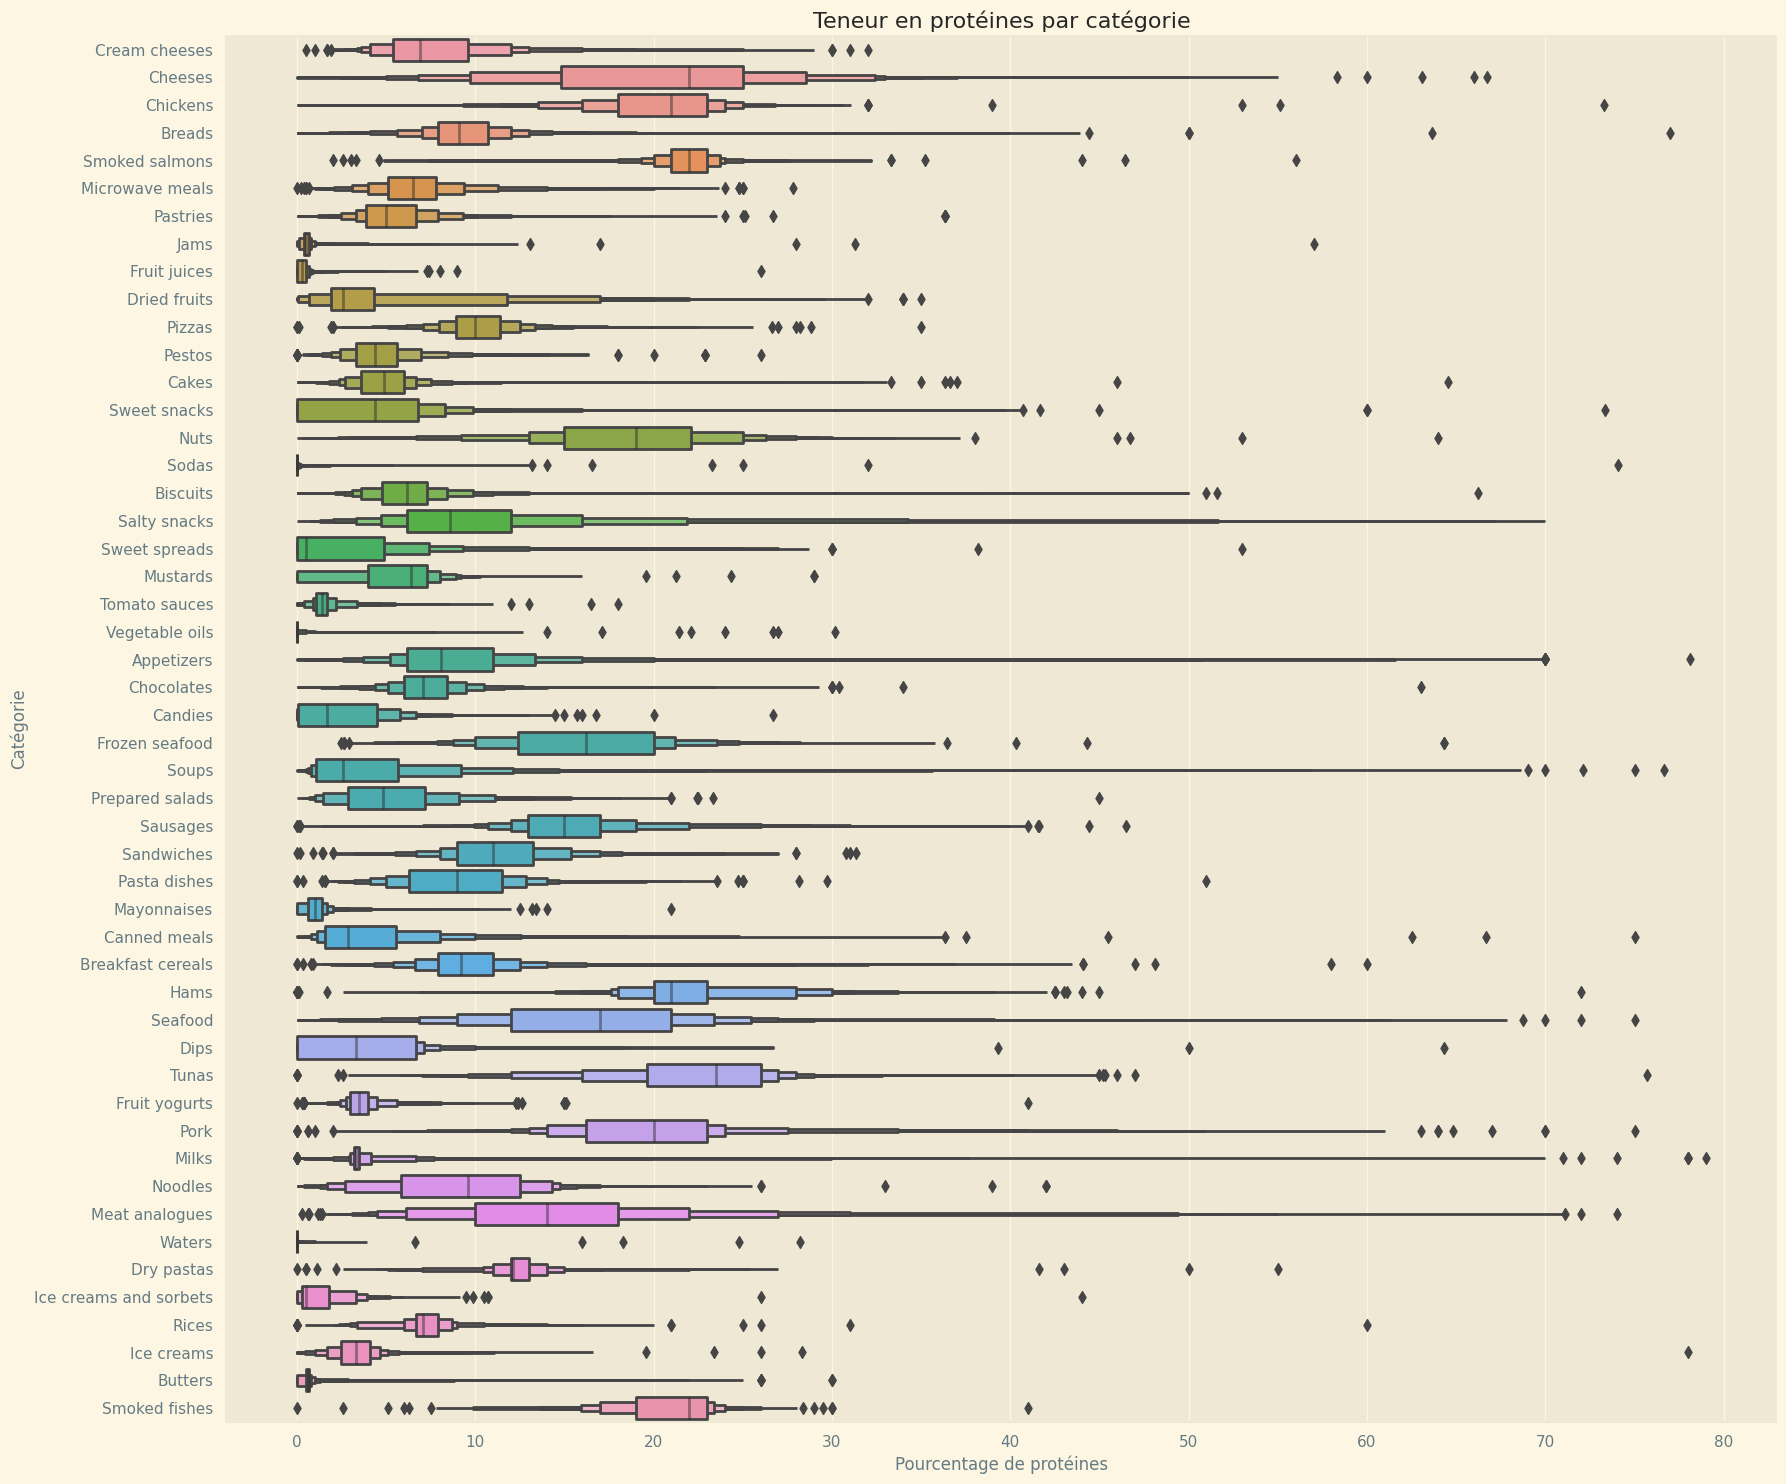

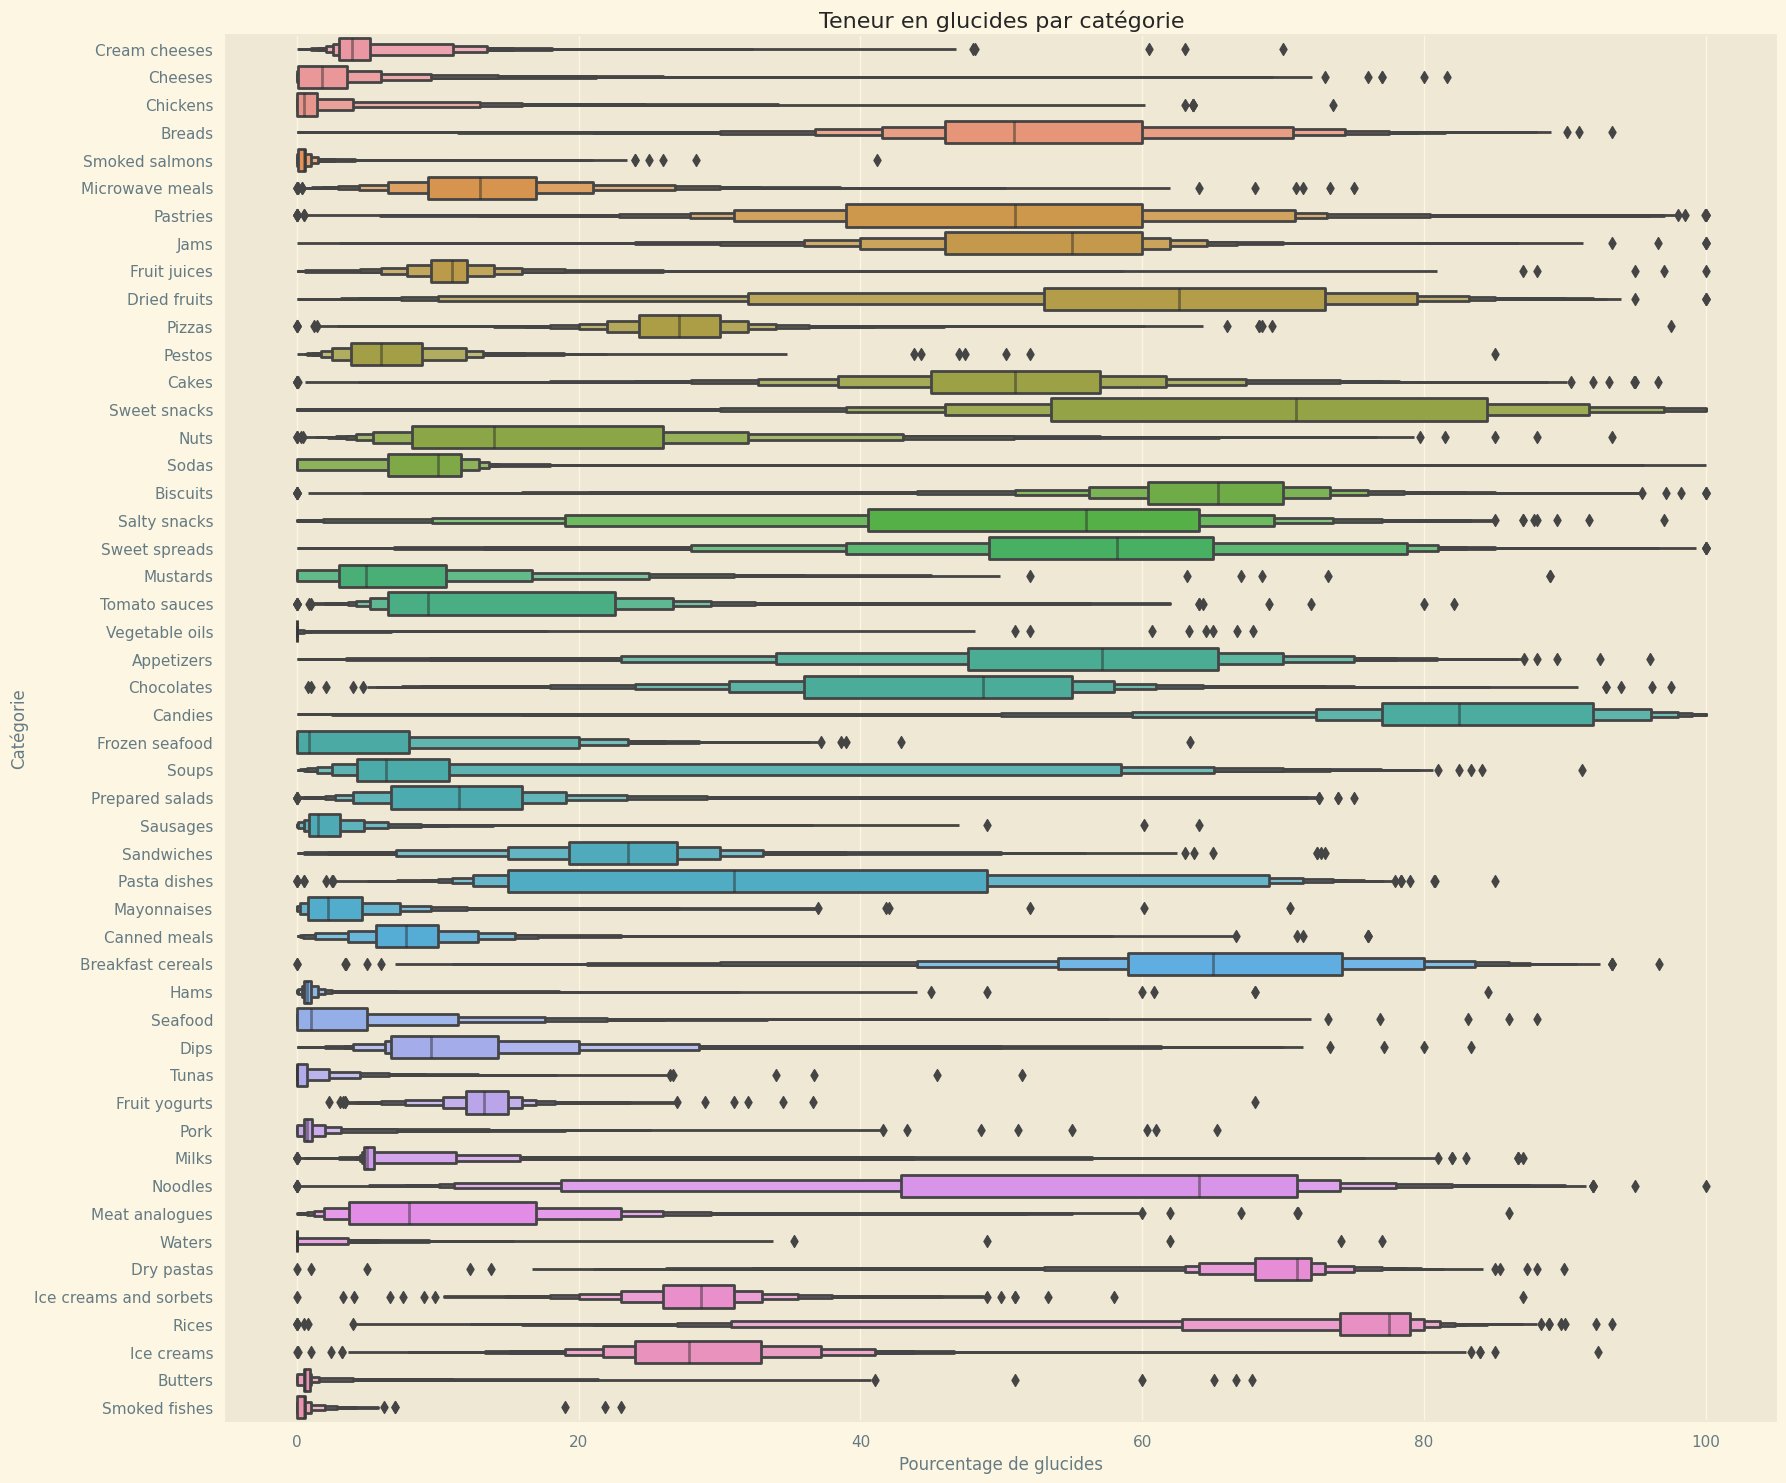

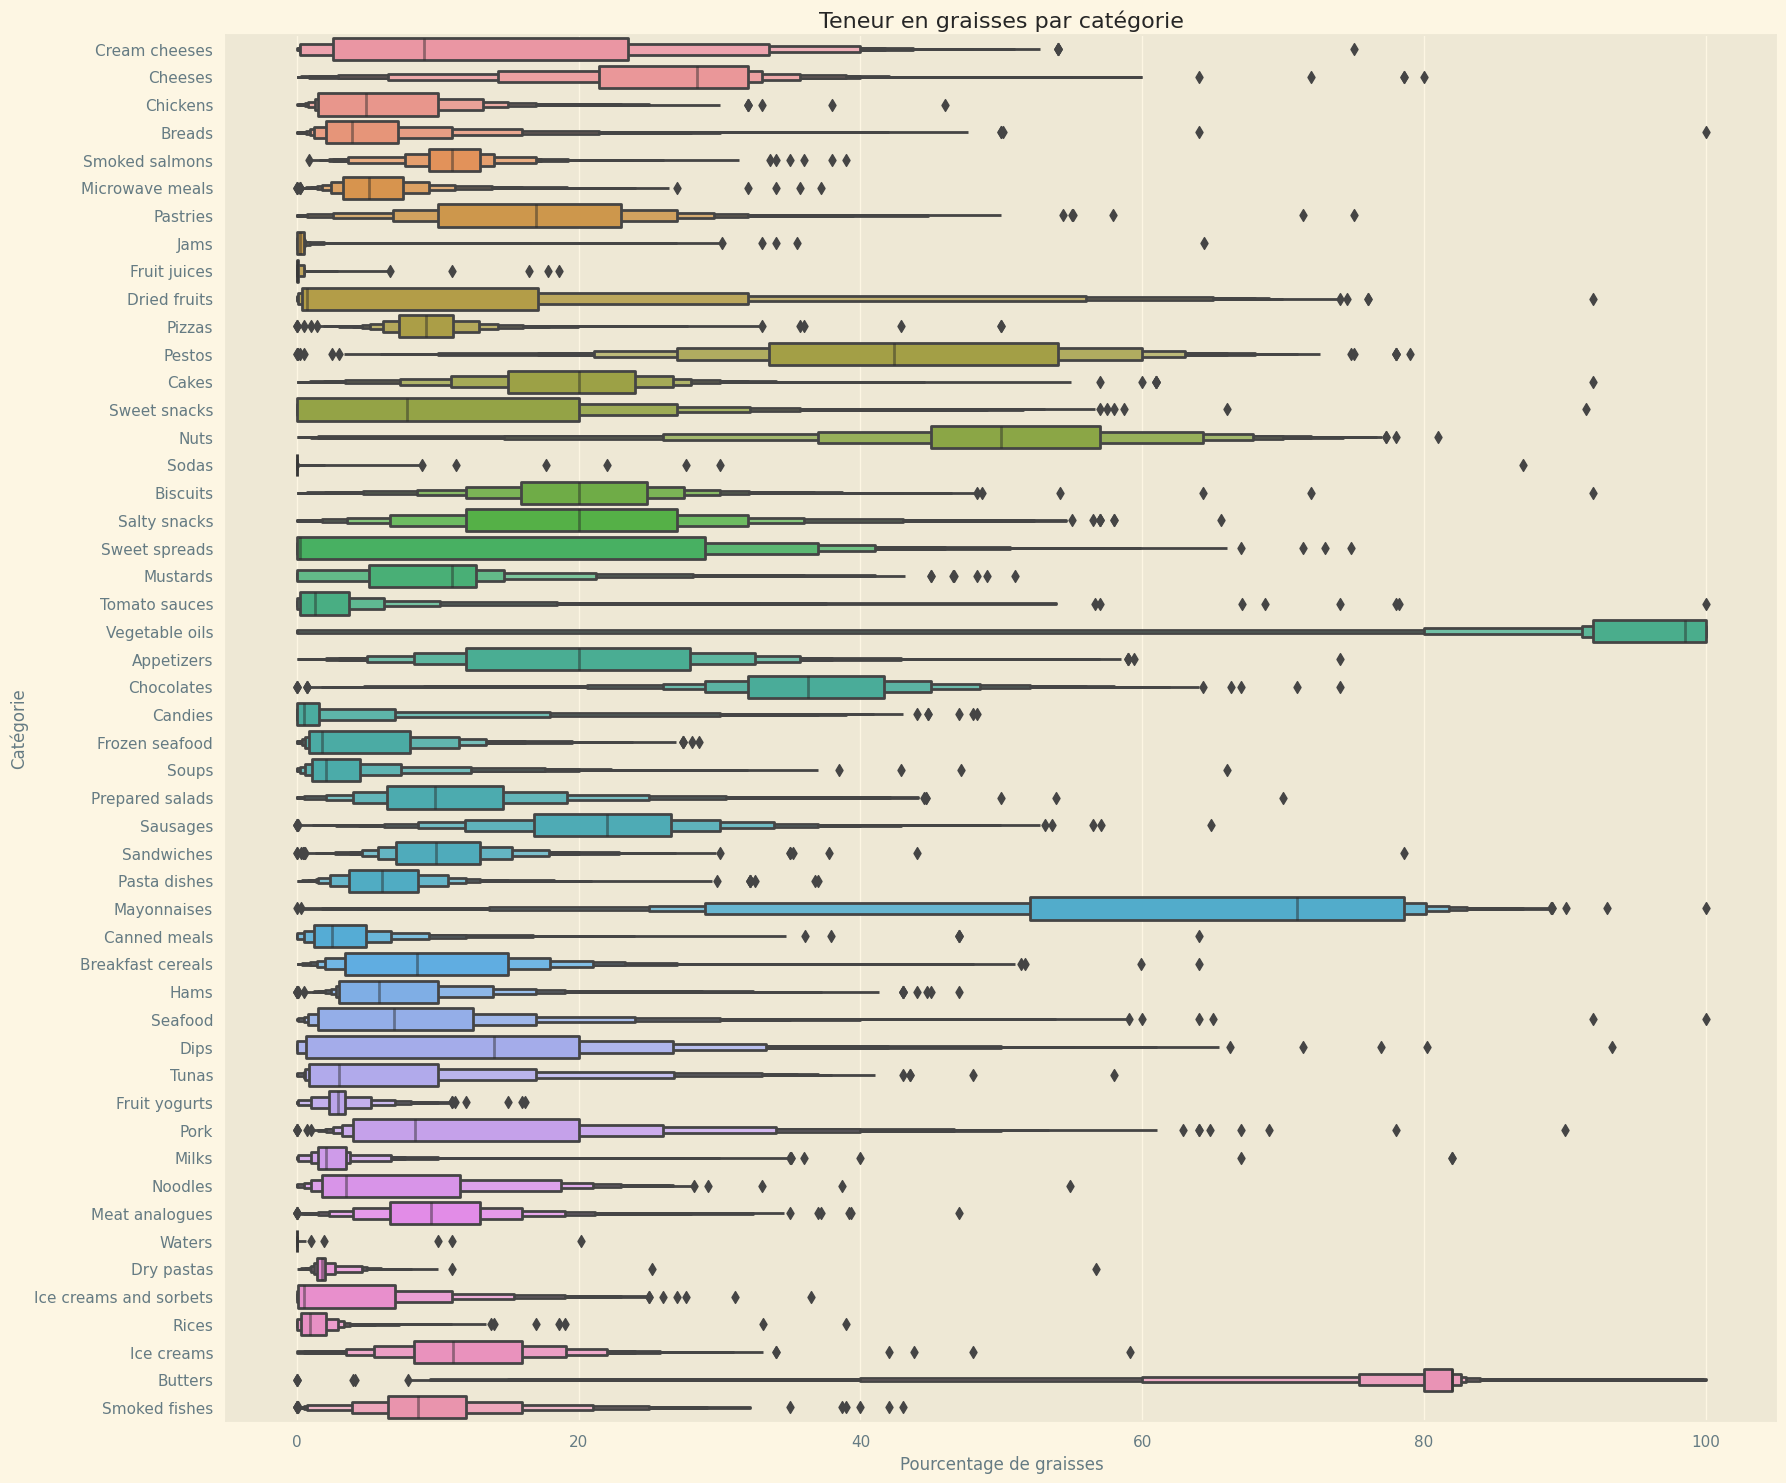

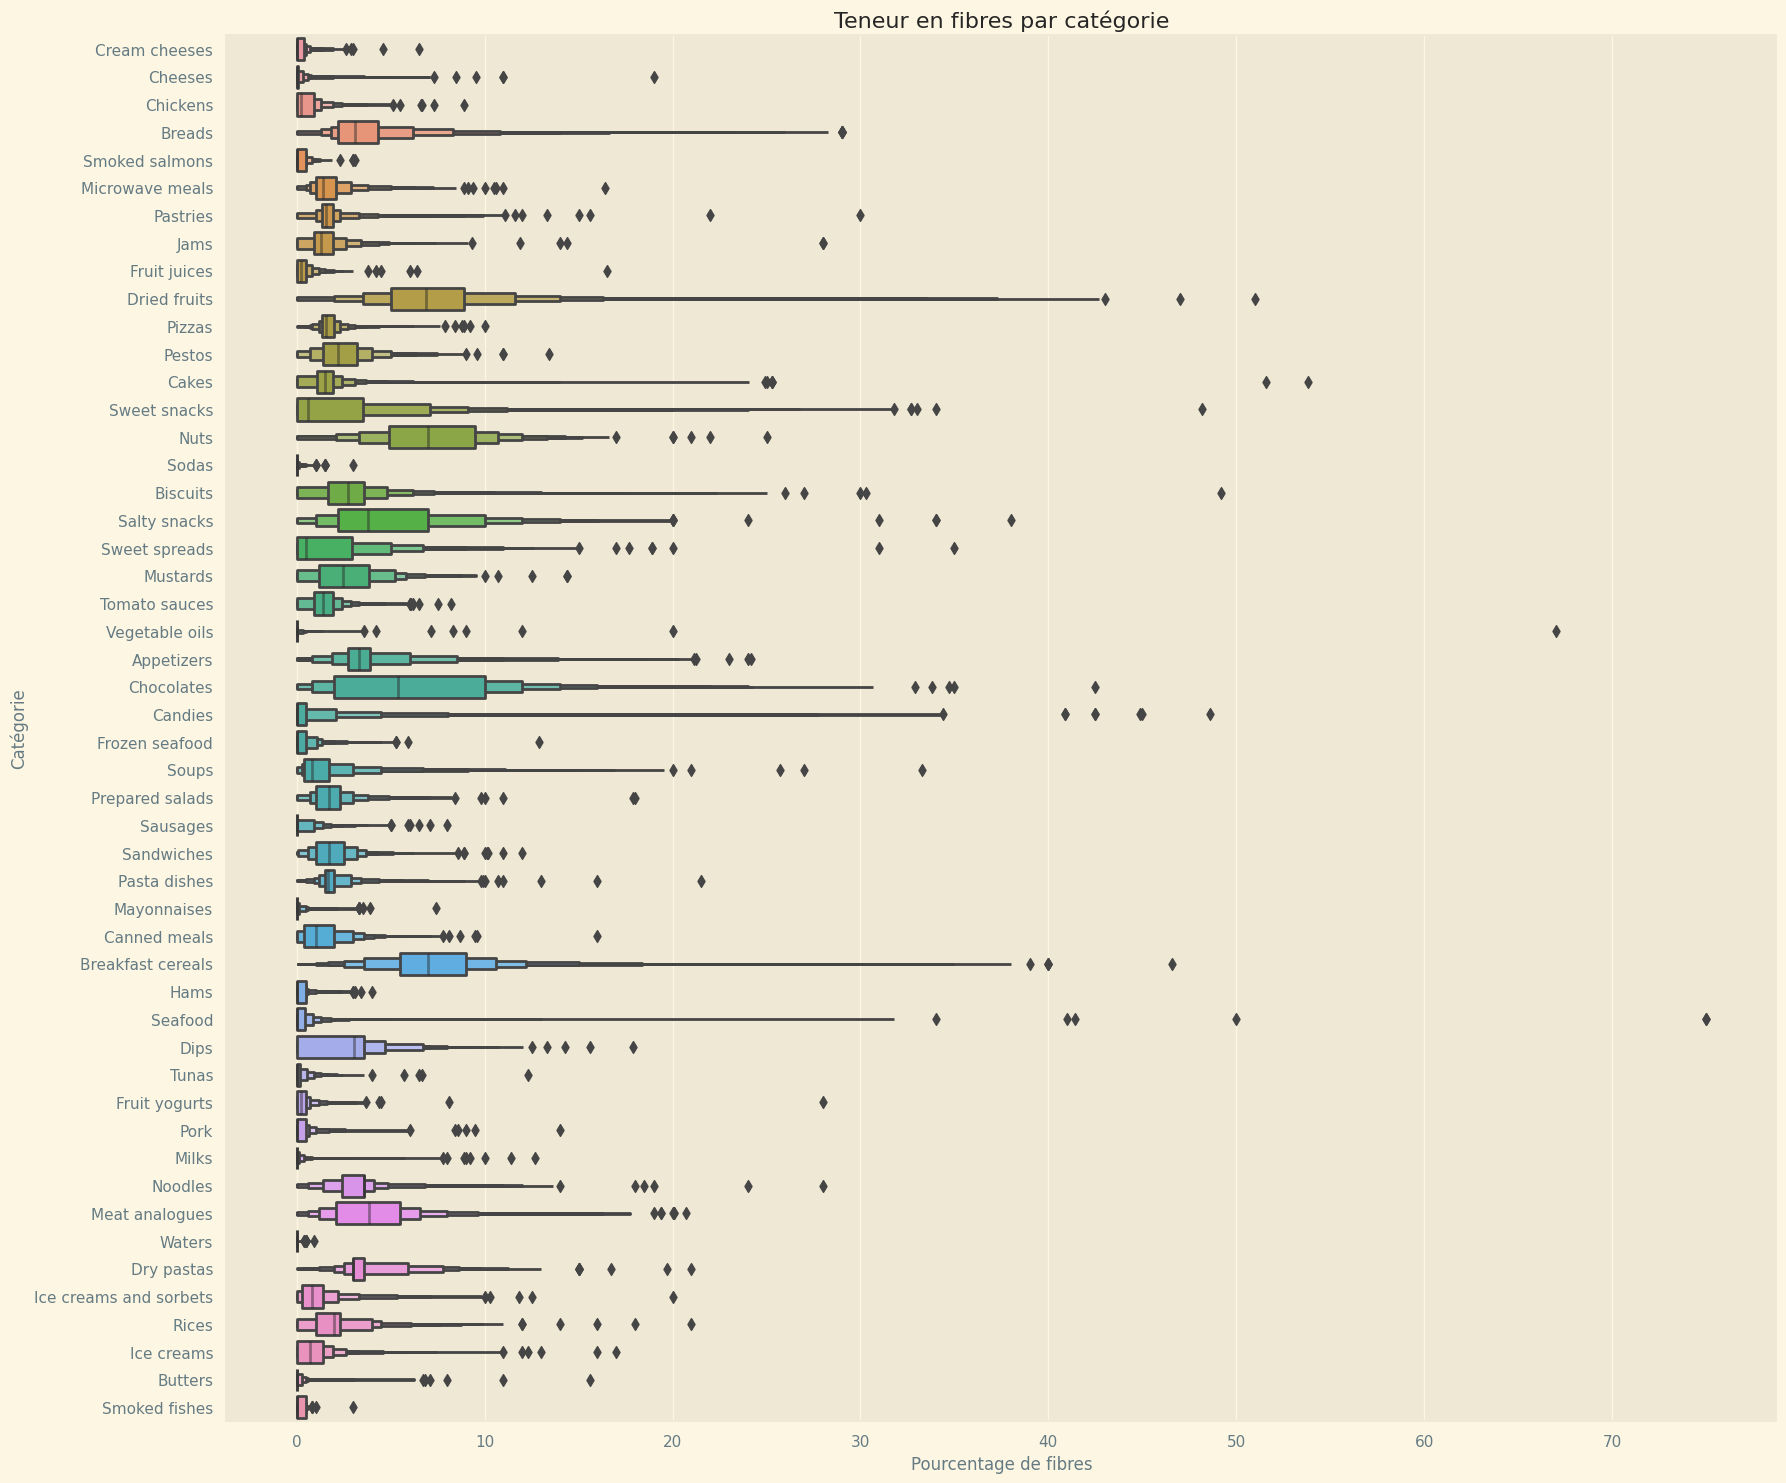

In [13]:
macro_cols_names = [
    ["proteins_100g", "protéines"],
    ["carbohydrates_100g", "glucides"],
    ["fat_100g", "graisses"],
    ["fiber_100g", "fibres"],
]

for macro_col_name in macro_cols_names:
    plt.style.use("Solarize_Light2")
    sns.boxenplot(
        y=products_df_sel_categ["select_category"],
        x=products_df_sel_categ[macro_col_name[0]],
        # flierprops=dict(markerfacecolor="0.75", markersize=3, linestyle="none"),
    ).set(
        xlabel=f"Pourcentage de {macro_col_name[1]}",
        ylabel="Catégorie",
        title=f"Teneur en {macro_col_name[1]} par catégorie",
    )
    sns.set(rc={"figure.figsize": (20, 18)})
    plt.show()


In [5]:
for macro_col_name in macro_cols_names:
    anova_result = sm.stats.anova_lm(
        ols(f"{macro_col_name[0]} ~ select_category", data=products_df_sel_categ).fit(),
        typ=2,
    )
    print(
        f"{macro_col_name[1]} : variable dépendante\ncatégorie : variable indépendante\n{anova_result}\n"
    )


protéines : variable dépendante
catégorie : variable indépendante
                       sum_sq        df             F  PR(>F)
select_category  1.388086e+07      49.0  15943.224132     0.0
Residual         5.295999e+06  298060.0           NaN     NaN

glucides : variable dépendante
catégorie : variable indépendante
                       sum_sq        df             F  PR(>F)
select_category  2.135462e+08      49.0  32070.084668     0.0
Residual         4.050413e+07  298060.0           NaN     NaN

graisses : variable dépendante
catégorie : variable indépendante
                       sum_sq        df             F  PR(>F)
select_category  9.342034e+07      49.0  23627.622457     0.0
Residual         2.405077e+07  298060.0           NaN     NaN

fibres : variable dépendante
catégorie : variable indépendante
                       sum_sq        df            F  PR(>F)
select_category  7.357180e+05      49.0  2892.486652     0.0
Residual         1.137111e+06  219058.0          NaN     N

In [6]:
categs_f_p = {}

for macro_col_name in macro_cols_names:
    categ_macro_vals = [
        products_df_sel_categ.loc[products_df_sel_categ["select_category"] == categ][
            macro_col_name[0]
        ]
        .dropna()
        .to_list()
        for categ in products_df_sel_categ["select_category"].unique()
    ]
    f_stat, p_val = stats.f_oneway(*categ_macro_vals)
    categs_f_p[macro_col_name[1]] = [f_stat, p_val]

for macro_col_name in macro_cols_names:
    print(
        f"{macro_col_name[1]} : variable dépendante\ncatégorie : variable indépendante\n"
        + f"statistique F : {categs_f_p[macro_col_name[1]][0]}\n"
        + f"valeur-p : {categs_f_p[macro_col_name[1]][1]}\n"
    )


protéines : variable dépendante
catégorie : variable indépendante
statistique F : 15943.224131798239
valeur-p : 0.0

glucides : variable dépendante
catégorie : variable indépendante
statistique F : 32070.084668292457
valeur-p : 0.0

graisses : variable dépendante
catégorie : variable indépendante
statistique F : 23627.62245702785
valeur-p : 0.0

fibres : variable dépendante
catégorie : variable indépendante
statistique F : 2892.4866517460828
valeur-p : 0.0



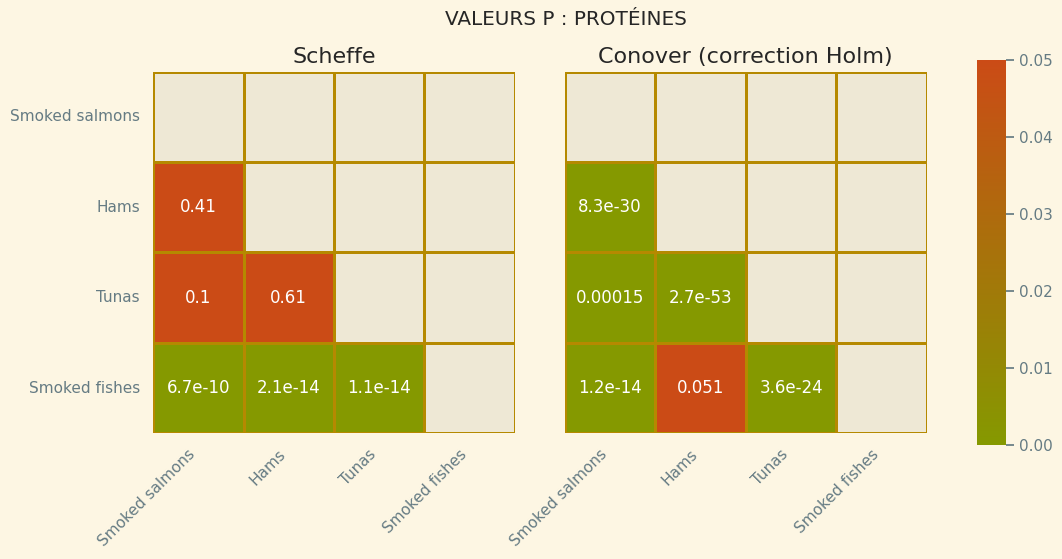

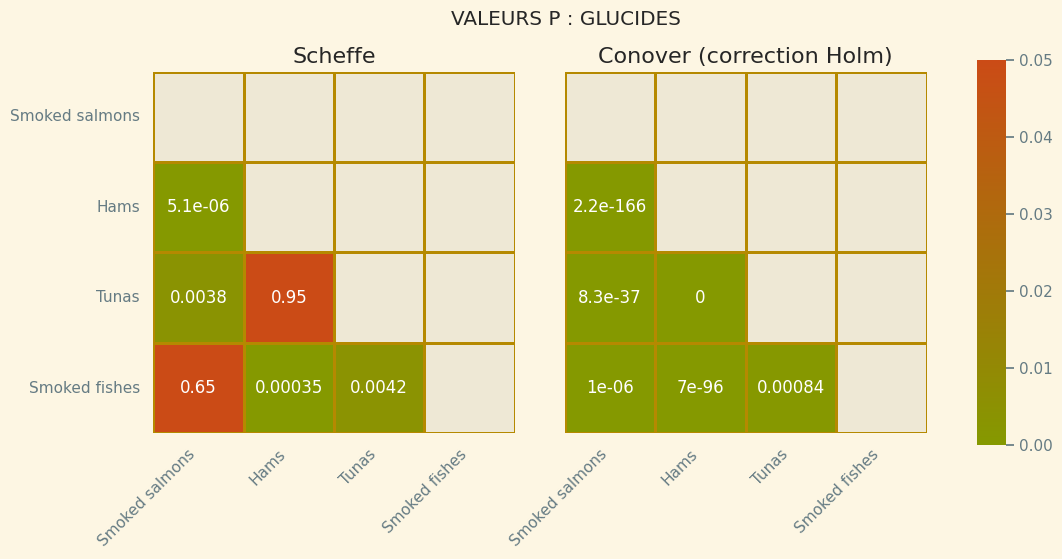

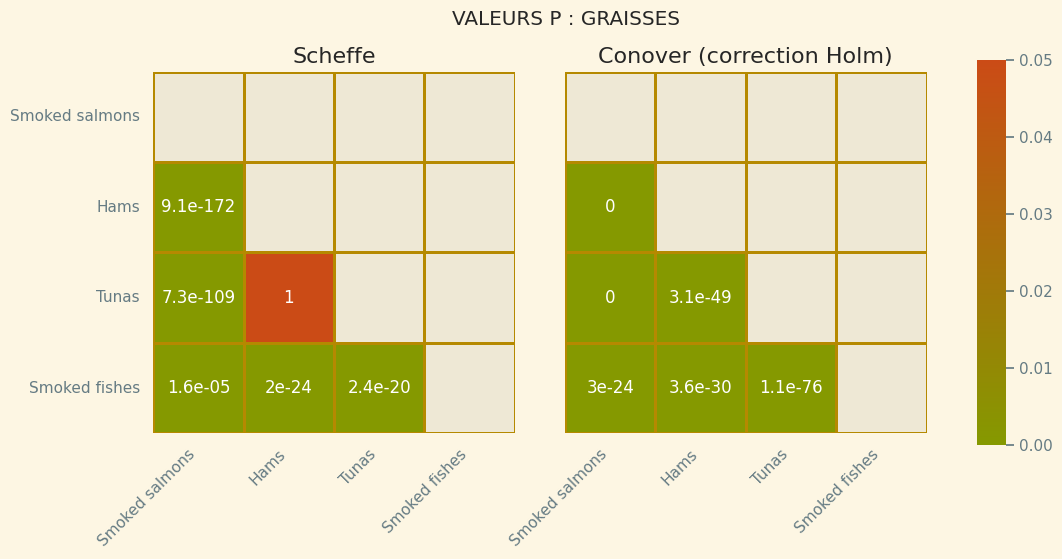

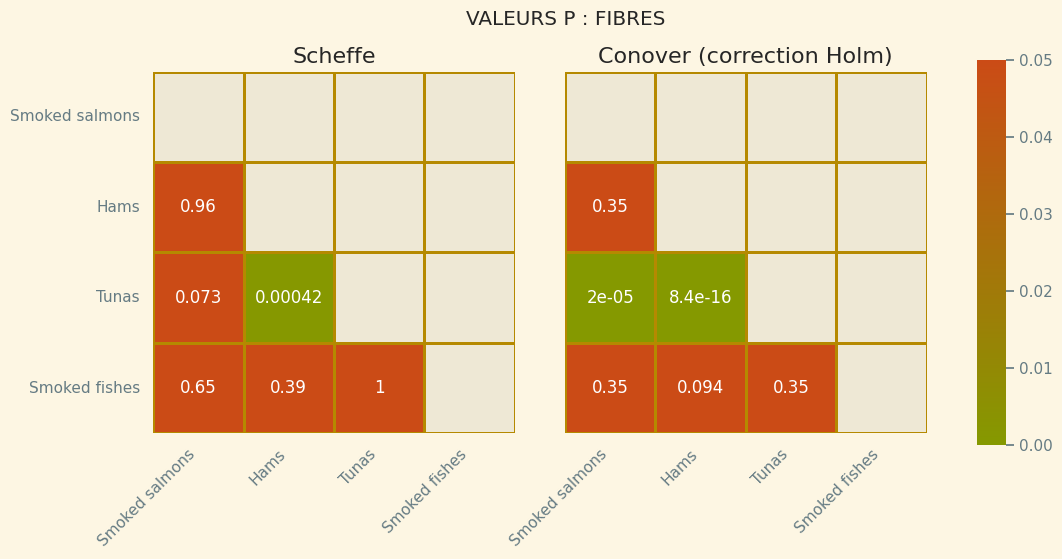

In [15]:
alpha = 0.05
macro_cat_pair_p_vals = {}

for macro_col_name in macro_cols_names:
    scheffe_df = sp.posthoc_scheffe(
        products_df_sel_categ, val_col=macro_col_name[0], group_col="select_category"
    )
    cat_pair_p_val = {}

    for index, row in scheffe_df.iterrows():
        for item in row.iteritems():
            if item[0] != index and item[1] > alpha:
                categs = [item[0], index]
                categs.sort()
                categs_str = ", ".join(categs)
                cat_pair_p_val[categs_str] = item[1]

    macro_cat_pair_p_vals[macro_col_name[0]] = cat_pair_p_val

holding_set = set()
first_loop = True

for macro in macro_cat_pair_p_vals:
    if first_loop:
        holding_set = set(macro_cat_pair_p_vals[macro].keys())
        first_loop = False
    else:
        holding_set = holding_set.intersection(macro_cat_pair_p_vals[macro].keys())

products_df_close_macro_categs = products_df_sel_categ.loc[
    products_df_sel_categ["select_category"].isin(", ".join(holding_set).split(", "))
]

for macro_col_name in macro_cols_names:
    ph_scheffe_df = sp.posthoc_scheffe(
        products_df_close_macro_categs,
        val_col=macro_col_name[0],
        group_col="select_category",
    )
    ph_scheffe_cols = ph_scheffe_df.columns.tolist()
    ph_scheffe_rows = ph_scheffe_df.index.tolist()
    ph_conov_df = sp.posthoc_conover(
        products_df_close_macro_categs[
            products_df_close_macro_categs[macro_col_name[0]].notna()
        ],
        val_col=macro_col_name[0],
        group_col="select_category",
        p_adjust="holm",
    )
    ph_conov_df = ph_conov_df[ph_scheffe_cols]
    ph_conov_df = ph_conov_df.reindex(ph_scheffe_rows)
    posthocs = [["Scheffe", ph_scheffe_df], ["Conover (correction Holm)", ph_conov_df]]
    fig, (ax1, ax2, ax3) = plt.subplots(
        1, 3, figsize=(11, 5), gridspec_kw={"width_ratios": [1, 1, 0.08]}
    )

    plt.style.use("Solarize_Light2")

    theme_clrs = plt.rcParams["axes.prop_cycle"].by_key()["color"]
    cmap = lsc.from_list("GrOrRd", [theme_clrs[2], theme_clrs[4]])
    first_loop = True

    for posthoc in posthocs:
        mask = np.zeros_like(posthoc[1])

        mask[np.triu_indices_from(mask)] = True
        if first_loop:
            g1 = sns.heatmap(
                posthoc[1],
                vmin=0.0,
                vmax=alpha,
                cmap=cmap,
                annot=True,
                linewidths=1,
                linecolor=theme_clrs[3],
                cbar=False,
                square=True,
                mask=mask,
                ax=ax1,
            )
            ax1.set_title(posthoc[0])
            first_loop = False
        else:
            g2 = sns.heatmap(
                posthoc[1],
                vmin=0.0,
                vmax=alpha,
                cmap=cmap,
                annot=True,
                linewidths=1,
                linecolor=theme_clrs[3],
                cbar_ax=ax3,
                square=True,
                mask=mask,
                ax=ax2,
            )
            ax2.set_title(posthoc[0])
        plt.suptitle(f"VALEURS P : {macro_col_name[1].upper()}")

    for ax in [ax1, ax2]:
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment="right")
        ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
    ax2.set_yticklabels([])
    plt.show()


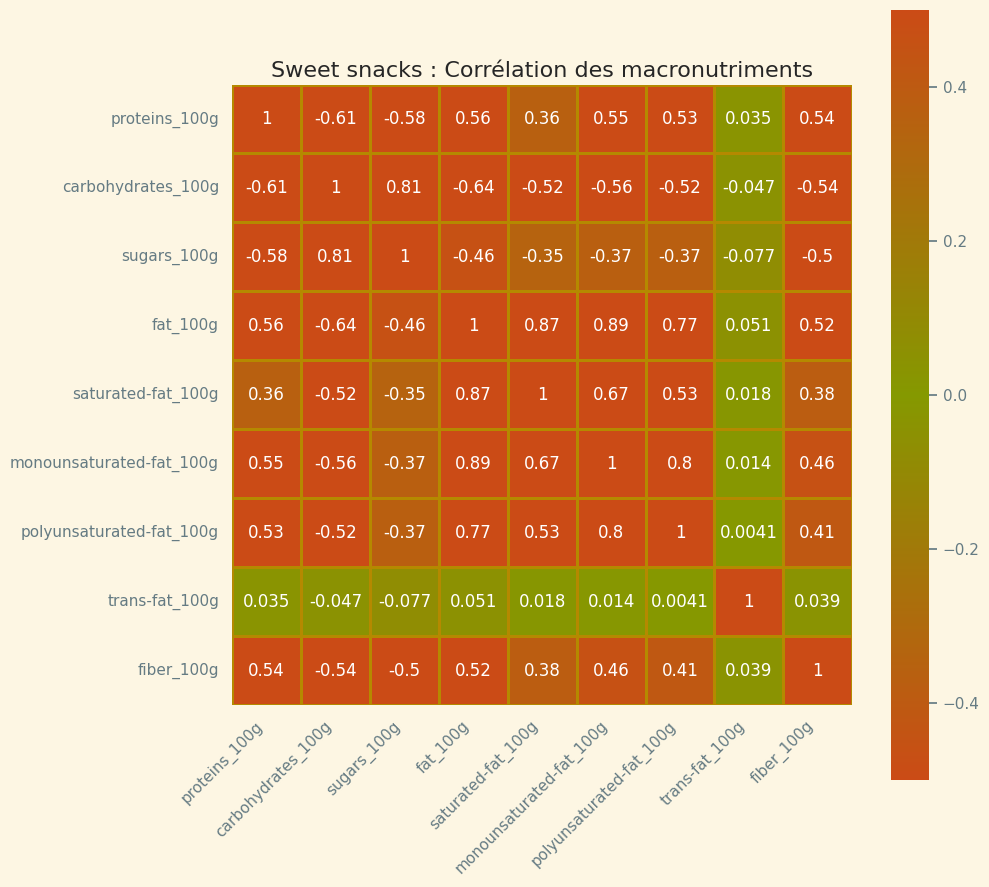

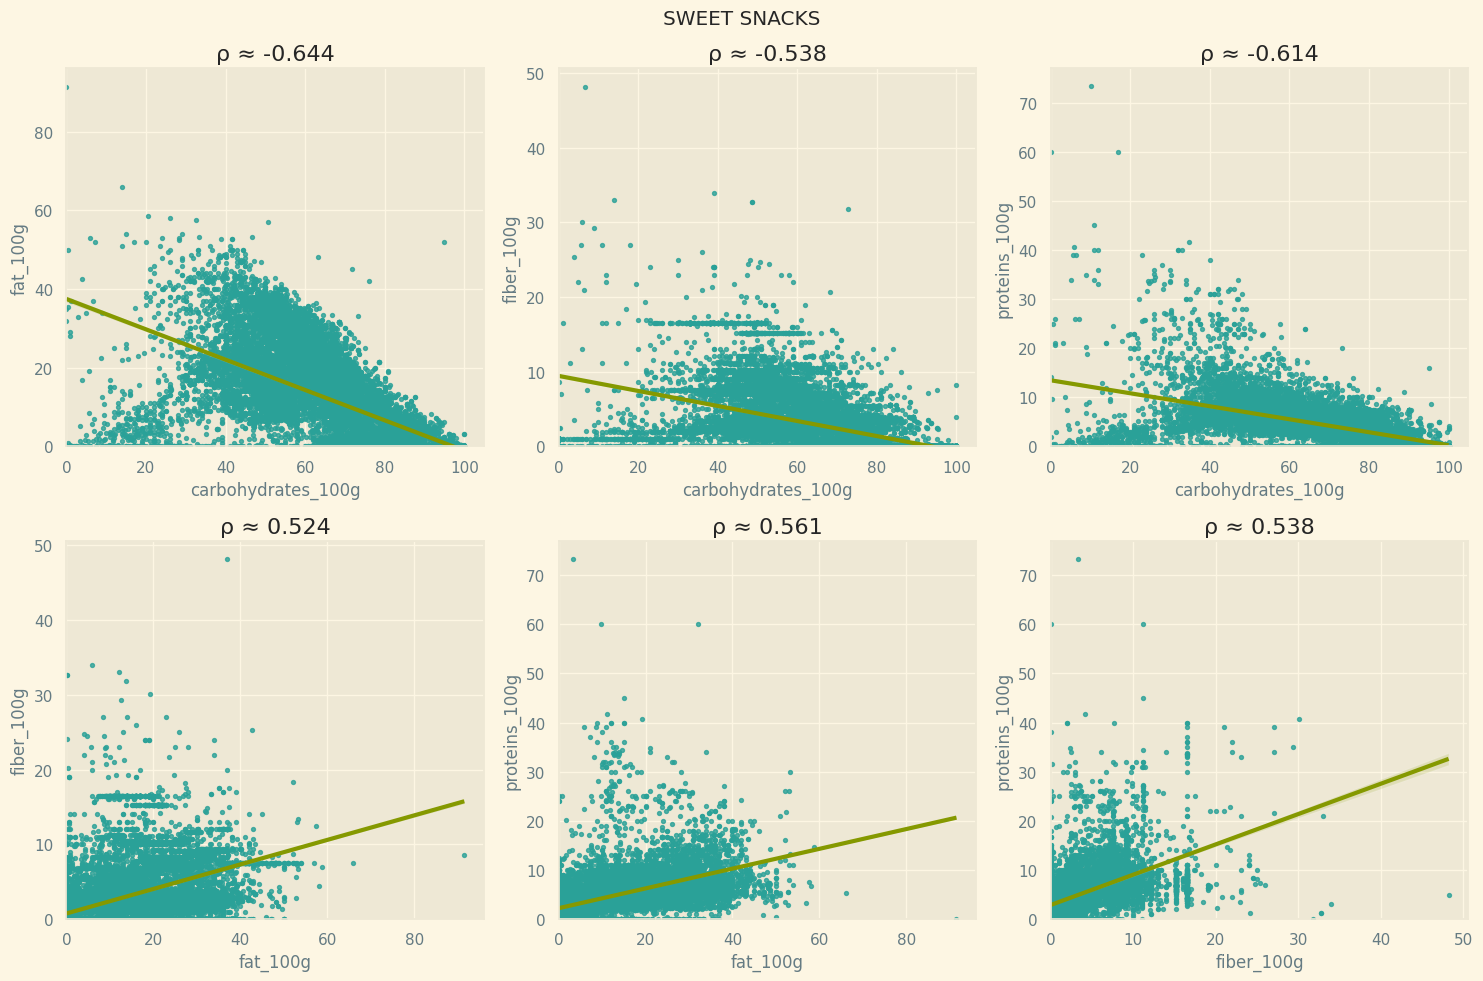

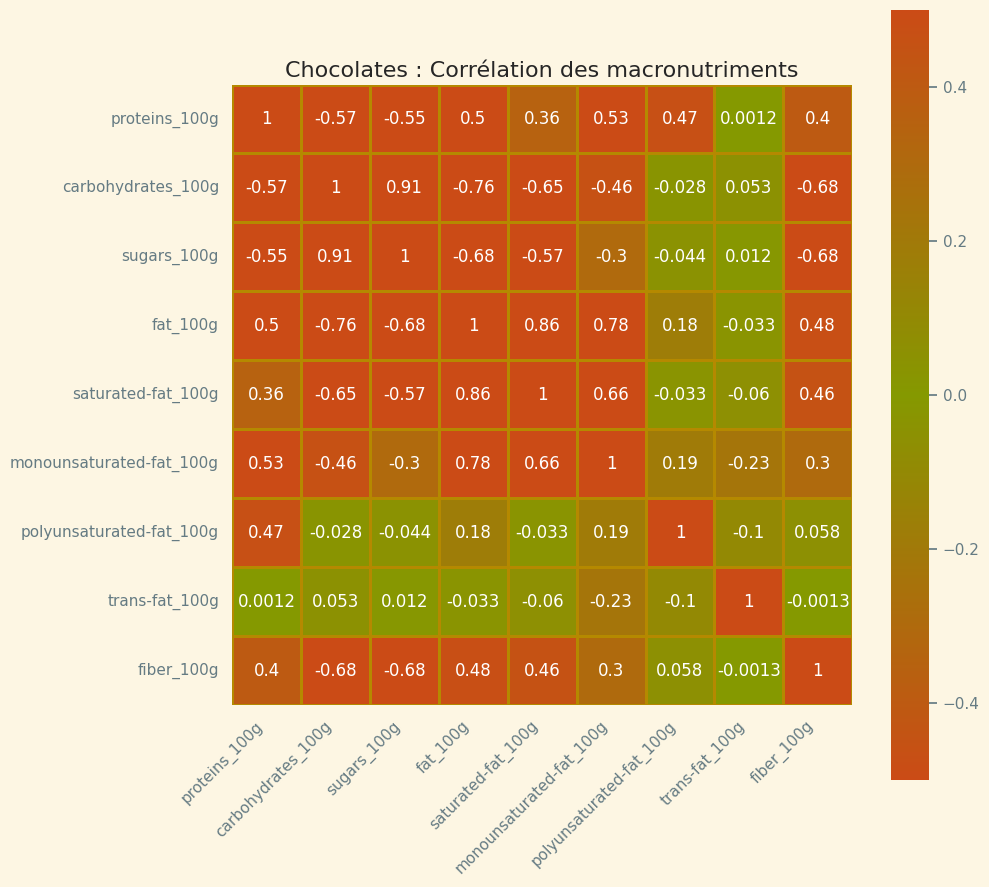

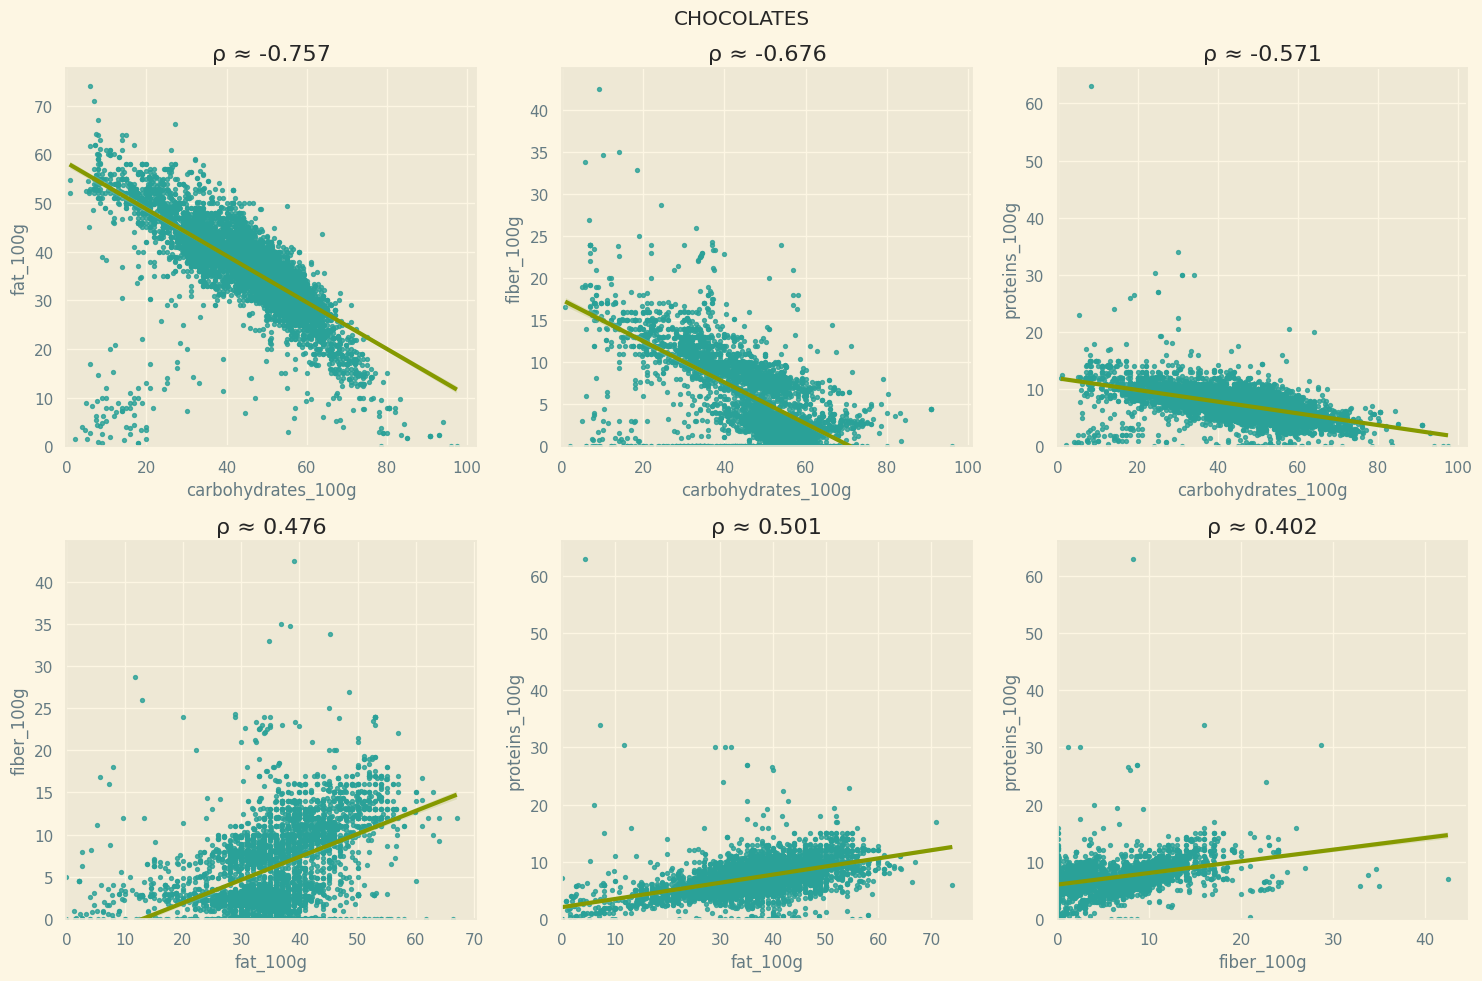

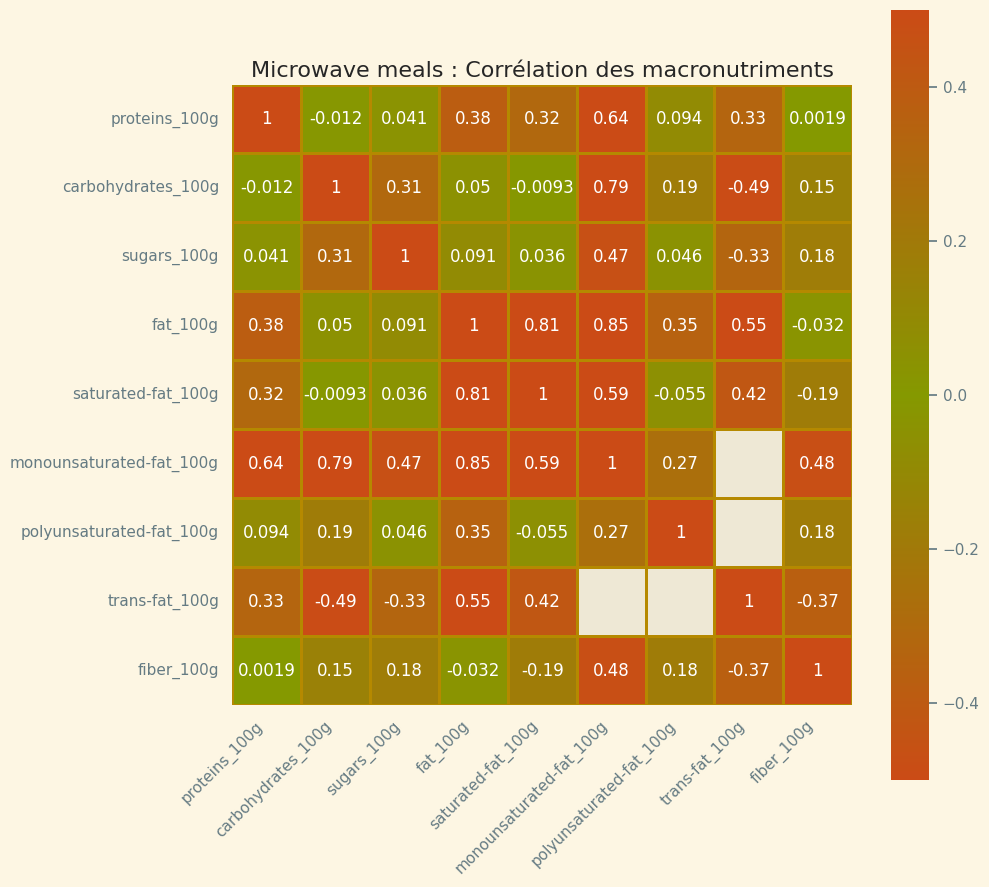

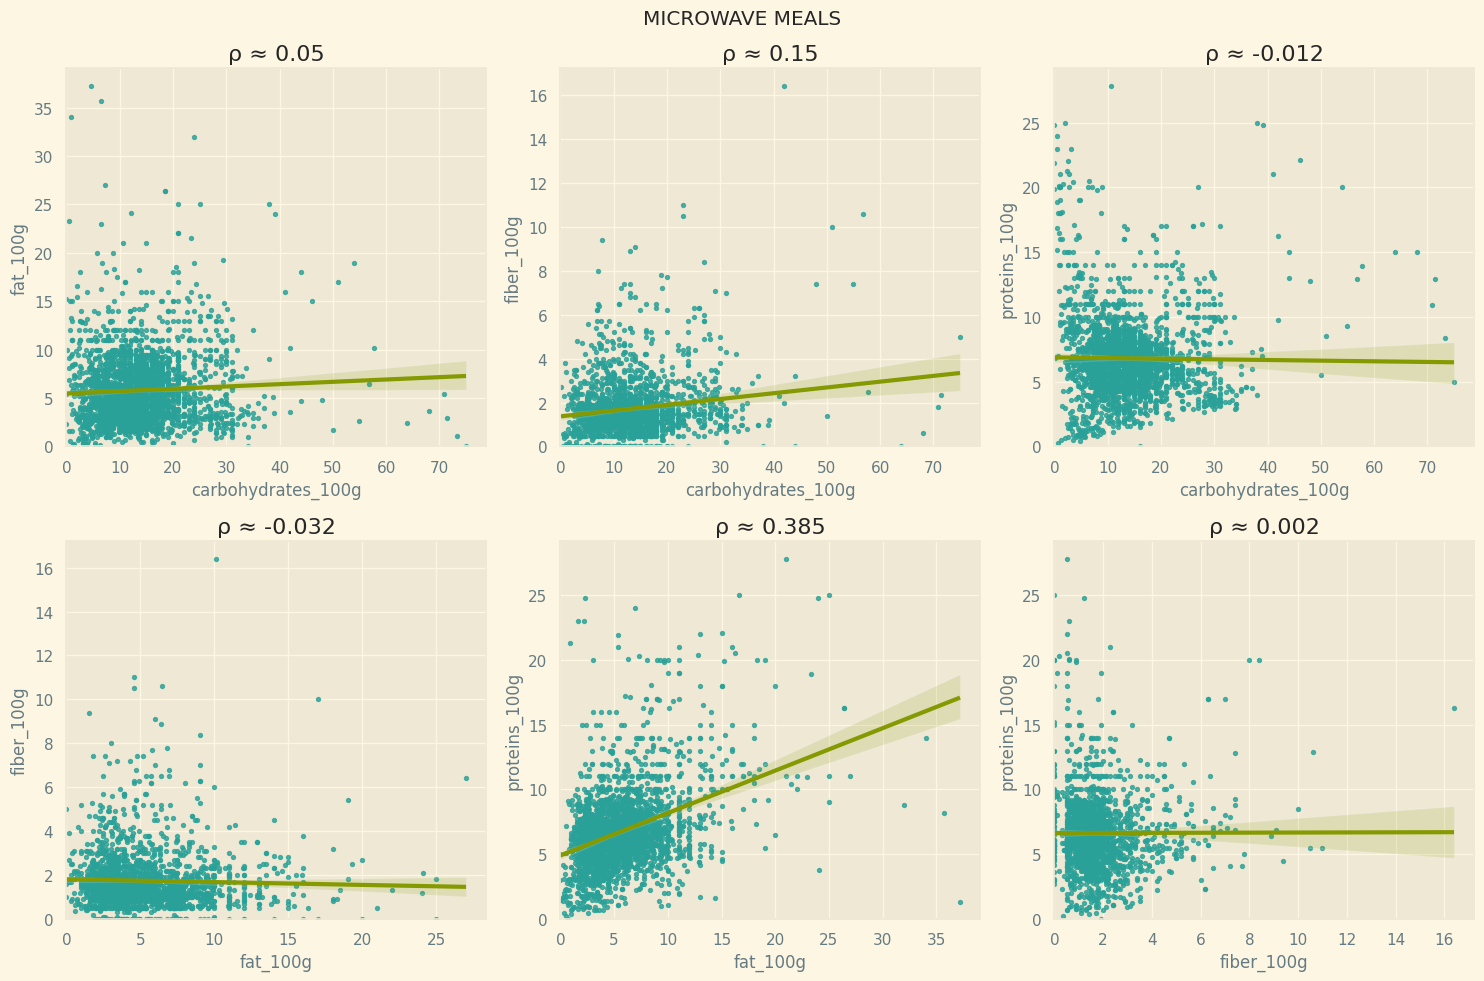

In [8]:
num_categs_bivar_high_corr = 2
num_categs_bivar_low_corr = 1
all_categs = set(products_df_sel_categ["select_category"].to_list())
cmap = lsc.from_list("RdGrRd", [theme_clrs[4], theme_clrs[2], theme_clrs[4]])
macro_perm_set = set()
corr_coeffs = []

for i in permutations([macro_col_name[0] for macro_col_name in macro_cols_names], 2):
    macro_perm_set.add(tuple(sorted(i)))

macro_perm_set = sorted(macro_perm_set)

for categ in all_categs:
    categ_df = products_df_sel_categ.loc[
        products_df_sel_categ["select_category"] == categ
    ]
    categ_corr_coeffs = {"category": categ}

    for macro_perm in macro_perm_set:
        macro_perm_categ_df = categ_df.loc[
            categ_df[macro_perm[0]].notnull() & categ_df[macro_perm[1]].notnull()
        ]
        rho = np.corrcoef(
            macro_perm_categ_df[macro_perm[0]].to_numpy(),
            macro_perm_categ_df[macro_perm[1]].to_numpy(),
        )[0][1]
        categ_corr_coeffs[f"{macro_perm[0]} {macro_perm[1]}"] = rho

    coeff_abs_total = 0

    for perm_coeff in categ_corr_coeffs:
        if type(categ_corr_coeffs[perm_coeff]) == np.float64:
            coeff_abs_total += abs(categ_corr_coeffs[perm_coeff])

    categ_corr_coeffs["abs total"] = coeff_abs_total

    corr_coeffs.append(categ_corr_coeffs)

corr_coeffs = sorted(corr_coeffs, key=lambda x: x["abs total"], reverse=True)

for categ_corr_coeffs in (
    corr_coeffs[:num_categs_bivar_high_corr] + corr_coeffs[-num_categs_bivar_low_corr:]
):
    categ_df = products_df_sel_categ.loc[
        products_df_sel_categ["select_category"] == categ_corr_coeffs["category"]
    ]
    categ_df_ext_macros = categ_df[
        [
            "proteins_100g",
            "carbohydrates_100g",
            "sugars_100g",
            "fat_100g",
            "saturated-fat_100g",
            "monounsaturated-fat_100g",
            "polyunsaturated-fat_100g",
            "trans-fat_100g",
            "fiber_100g",
        ]
    ]
    categ_df_ext_macros_corr = categ_df_ext_macros.corr()
    fig, ax = plt.subplots(figsize=(10, 10))

    plt.style.use("Solarize_Light2")
    sns.heatmap(
        categ_df_ext_macros_corr,
        vmin=-0.5,
        vmax=0.5,
        cmap=cmap,
        annot=True,
        linewidths=1,
        linecolor=theme_clrs[3],
        square=True,
        ax=ax,
    )
    ax.set_title(f"{categ_corr_coeffs['category']} : Corrélation des macronutriments")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment="right")
    plt.show()

    fig, (ax1, ax2) = plt.subplots(ncols=3, nrows=2, figsize=(15, 10))
    sp_locs = [i for i in ax1] + [i for i in ax2]
    loop_num = 0

    for macro_perm in macro_perm_set:
        rp = sns.regplot(
            data=categ_df,
            x=macro_perm[0],
            y=macro_perm[1],
            ax=sp_locs[loop_num],
            line_kws={"color": theme_clrs[2]},
            scatter_kws={"color": theme_clrs[1], "s": 8},
        )
        rp.set(xlim=(0, None))
        rp.set(ylim=(0, None))

        test_df = products_df_sel_categ.loc[
            products_df_sel_categ["select_category"] == "Cheeses"
        ]
        test_df = test_df.loc[
            test_df["proteins_100g"].notnull() & test_df["fiber_100g"].notnull()
        ]
        fiber_list = test_df["fiber_100g"].to_list()

        sp_locs[loop_num].set_title(
            f'\u03C1 \u2248 {round(categ_corr_coeffs[f"{macro_perm[0]} {macro_perm[1]}"], 3)}'
        )
        loop_num += 1

    plt.suptitle(categ_corr_coeffs["category"].upper())
    plt.tight_layout()
    plt.show()


In [9]:
keto_train_df = pd.read_csv("keto_training.csv")
features = keto_train_df[
    [
        "energy-kcal_100g",
        "proteins_100g",
        "carbohydrates_100g",
        "sugars_100g",
        "fat_100g",
        "saturated-fat_100g",
        "monounsaturated-fat_100g",
        "polyunsaturated-fat_100g",
        "trans-fat_100g",
        "fiber_100g",
    ]
]
feature_list = list(features.columns)
features = np.array(features)
labels = np.array(keto_train_df["keto_score"])

display(features)
display(labels)

features_nancounts = np.array([np.isnan(arr).sum() for arr in features])
low_cnts = []
many_nans_idxs = []

for idx, cnt in enumerate(np.bincount(features_nancounts)):
    if cnt <= 10:
        low_cnts.append(idx)
for idx, arr in enumerate(features):
    if np.isnan(arr).sum() in low_cnts:
        many_nans_idxs.append(idx)
for idx in many_nans_idxs:
    print(features[idx])


array([[8.50000e+02, 0.00000e+00, 0.00000e+00, ..., 1.00000e+01,
                nan, 0.00000e+00],
       [8.85714e+02, 0.00000e+00, 0.00000e+00, ..., 1.35710e+01,
                nan, 0.00000e+00],
       [8.50000e+02, 0.00000e+00, 0.00000e+00, ..., 1.00000e+01,
                nan, 0.00000e+00],
       ...,
       [3.73171e+02, 1.29270e+01, 5.58540e+01, ..., 2.25600e+00,
                nan, 1.00000e+01],
       [3.45270e+02, 1.08110e+01, 6.41890e+01, ..., 7.43000e-01,
                nan, 1.01350e+01],
       [3.38000e+02, 1.46670e+01, 5.93330e+01, ..., 1.26700e+00,
                nan, 1.06670e+01]])

array([5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 2, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 2, 2, 2, 2, 1, 1, 1, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 2, 2, 2,
       2, 2, 2, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1])

[96.46  18.584  0.     0.     1.77   0.442    nan    nan  0.     0.   ]
[13.58   1.44   0.247  0.247  0.7    0.124    nan    nan  0.     0.453]
[12.5    0.458  0.458  0.083  1.083  0.083    nan    nan  0.     0.293]
[19.069  0.212  0.254  0.     2.034  1.822    nan    nan  0.     0.   ]
[133.334   0.667  11.334     nan  10.      9.334   0.      0.        nan
   0.   ]
[27.097  0.968  4.645    nan  0.194    nan    nan    nan  0.     1.226]
[640.  12.  24.  12.  48.  28.  nan  nan   0.  12.]
[571.429  17.143  11.786     nan  50.      6.786  18.214  21.429     nan
  14.286]
[445.313  18.75   34.375     nan  18.75    3.594   6.094   8.906     nan
  18.75 ]
[347.857  10.357  72.5       nan   2.143   0.357   0.714   0.714     nan
     nan]
[3.3125e+02 1.5313e+01 6.4375e+01        nan 1.8750e+00 3.1300e-01
 3.1300e-01 1.2500e+00        nan        nan]
[100.      8.462   3.846   1.538   3.462   0.385     nan     nan     nan
   4.615]
[111.224   2.347  21.633     nan   0.816   0.153   0.306   0

In [10]:
features = IterativeImputer(sample_posterior=True, min_value=0).fit_transform(features)

for idx in many_nans_idxs:
    print(features[idx])


[9.64600000e+01 1.85840000e+01 0.00000000e+00 0.00000000e+00
 1.77000000e+00 4.42000000e-01 1.50702088e-01 8.05059108e-02
 0.00000000e+00 0.00000000e+00]
[13.58        1.44        0.247       0.247       0.7         0.124
  0.99674592  0.          0.          0.453     ]
[12.5         0.458       0.458       0.083       1.083       0.083
  4.36400751  0.          0.          0.293     ]
[19.069  0.212  0.254  0.     2.034  1.822  0.     0.     0.     0.   ]
[133.334        0.667       11.334        8.32286112  10.
   9.334        0.           0.           1.70604148   0.        ]
[27.097       0.968       4.645       5.12045654  0.194       2.80313448
  0.          0.          0.          1.226     ]
[640.          12.          24.          12.          48.
  28.          11.1627333    7.98348135   0.          12.        ]
[571.429       17.143       11.786        0.          50.
   6.786       18.214       21.429        1.28119239  14.286     ]
[445.313       18.75        34.375      

In [11]:
def train_rand_forest(
    passes=100, test_size_range=[0.15, 0.25], n_estim_range=[100, 1000]
):
    lowest_mar = [rfr(), 5, 0.0]

    for i in range(passes):
        train_features, test_features, train_labels, test_labels = train_test_split(
            features,
            labels,
            test_size=random.uniform(test_size_range[0], test_size_range[1]),
        )
        rf = rfr(n_estimators=random.randrange(n_estim_range[0], n_estim_range[1], 1))

        rf.fit(train_features, train_labels)

        predictions = np.rint(rf.predict(test_features)).astype(int)
        errors = abs(predictions - test_labels)
        mean_abs_err = np.mean(errors)
        accuracy_pct = round(100 - np.mean(100 * (errors / test_labels)), 2)

        if mean_abs_err < lowest_mar[1]:
            lowest_mar = [rf, mean_abs_err, accuracy_pct]

    return [lowest_mar[0], f"Accuracy: {lowest_mar[2]}%"]


keto_ranker_rf = rfr()
accuracy_str = ""

if not os.path.isfile("keto_ranker_accuracy.pkl"):
    train_rand_forest_return = train_rand_forest(
        passes=1000, test_size_range=[0.15, 0.3], n_estim_range=[500, 1500]
    )
    keto_ranker_rf, accuracy_str = train_rand_forest_return

    pickle.dump(train_rand_forest_return, open("keto_ranker_accuracy.pkl", "wb"))
else:
    keto_ranker_rf, accuracy_str = pickle.load(open("keto_ranker_accuracy.pkl", "rb"))

print(f"{keto_ranker_rf}\n{accuracy_str}")


RandomForestRegressor(n_estimators=1349)
Accuracy: 93.85%


In [17]:
if not os.path.isfile("features_keto_ranks.pkl"):
    features = products_df_sel_categ[
        [
            "energy-kcal_100g",
            "proteins_100g",
            "carbohydrates_100g",
            "sugars_100g",
            "fat_100g",
            "saturated-fat_100g",
            "monounsaturated-fat_100g",
            "polyunsaturated-fat_100g",
            "trans-fat_100g",
            "fiber_100g",
        ]
    ]
    feature_list = list(features.columns)
    features = IterativeImputer(sample_posterior=True, min_value=0).fit_transform(
        np.array(features)
    )
    keto_ranks = np.rint(keto_ranker_rf.predict(features)).astype(int)

    pickle.dump([features, keto_ranks], open("features_keto_ranks.pkl", "wb"))
else:
    features, keto_ranks = pickle.load(open("features_keto_ranks.pkl", "rb"))


In [24]:
filled_macros_df = pd.DataFrame(features, columns=feature_list)
products_df_sel_categ[feature_list] = filled_macros_df[feature_list]

products_df_sel_categ.insert(
    loc=products_df_sel_categ.columns.get_loc("sodium_100g") + 1,
    column="keto_score",
    value=keto_ranks,
)
products_df_sel_categ["keto_score"] = products_df_sel_categ["keto_score"].replace(
    [5, 4, 3, 2, 1], ["A", "B", "C", "D", "F"]
)

with pd.option_context("display.max_columns", None):
    display(products_df_sel_categ)


,code,product_name,brands,primary_category,secondary_category,tertiary_category,select_category,energy-kcal_100g,proteins_100g,carbohydrates_100g,sugars_100g,fat_100g,saturated-fat_100g,monounsaturated-fat_100g,polyunsaturated-fat_100g,trans-fat_100g,fiber_100g,sodium_100g,keto_score,Biscuits,Cheeses,Sweet snacks,Breads,Cakes,Chocolates,Hams,Pastries,Milks,Sausages,Chickens,Candies,Sodas,Vegetable oils,Jams,Pizzas,Breakfast cereals,Waters,Ice creams,Fruit juices,Nuts,Sweet spreads,Dried fruits,Pork,Tomato sauces,Rices,Appetizers,Soups,Seafood,Smoked salmons,Mayonnaises,Salty snacks,Sandwiches,Ice creams and sorbets,Fruit yogurts,Noodles,Meat analogues,Microwave meals,Prepared salads,Butters,Pasta dishes,Smoked fishes,Cream cheeses,Dips,Frozen seafood,Canned meals,Tunas,Dry pastas,Mustards,Pestos
0,00000000000026772226,Skyr,Danone,Skyr,Cream cheeses,Dairy desserts,Cream cheeses,57.0,10.00,3.9,3.9,0.20,0.100,0.000000,0.000000,0.502234,2.039681,0.0360,C,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,0000000005005,Abondance,None,Abondance,French cheeses,Cheeses,Cheeses,397.0,25.00,0.1,0.1,33.00,21.600,8.961429,0.000000,0.000000,0.000000,0.5200,B,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0000000005166,cuisse de poulet direct au four curry,None,Chicken thighs,Chickens,Poultries,Chickens,197.0,17.00,3.0,0.9,13.00,4.000,5.335742,1.969618,0.171311,2.243729,0.4400,B,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0000000005241,Bagel,None,Bagel breads,Special breads,Breads,Breads,197.0,8.40,28.7,3.0,5.00,1.100,2.009231,1.507692,0.000000,1.727260,0.1868,D,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0000000005470,BAguette bressan,Crousresto',Baguettes,Breads,Cereals and potatoes,Breads,160.0,9.50,25.2,0.6,2.20,0.371,0.951000,0.877000,0.000000,1.600000,0.1432,D,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298105,9999900002553,Chocolat de Couverture Noir,Barry,Dark chocolates,Chocolates,Cocoa and its products,Chocolates,584.0,7.60,30.7,26.9,46.90,28.200,8.609910,9.541332,0.129336,6.742250,0.0120,D,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
298106,9999990403179,Brownies cookies,None,Biscuits and cakes,Sweet snacks,Snacks,Sweet snacks,460.0,6.61,59.1,40.7,21.18,12.930,2.270000,2.270000,0.000000,3.400000,0.2450,D,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
298107,9999991149090,Riz parfumé,King Elephant,Aromatic rices,Rices,Cereal grains,Rices,351.0,7.00,80.0,0.0,0.50,0.000,0.000000,0.000000,0.000000,2.000000,0.0000,D,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
298108,9999999004360,Minis beignets,None,Sweet Fritters,Sweet snacks,Snacks,Sweet snacks,333.0,7.40,30.9,10.4,20.20,6.000,3.208000,1.072000,0.000000,16.500000,0.4400,F,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [132]:
pca = PCA(n_components=3)
feature_list = [
    "energy-kcal_100g",
    "proteins_100g",
    "carbohydrates_100g",
    "sugars_100g",
    "fat_100g",
    # "saturated-fat_100g",
    # "monounsaturated-fat_100g",
    # "polyunsaturated-fat_100g",
    # "trans-fat_100g",
    "fiber_100g",
]
principal_components = pca.fit_transform(
    StandardScaler().fit_transform(products_df_sel_categ.loc[:, feature_list].values)
)
pca_df_cols = [
    "principal_component_1",
    "principal_component_2",
    "principal_component_3",
]
pca_df = pd.concat(
    [
        pd.DataFrame(data=principal_components, columns=pca_df_cols),
        products_df_sel_categ[["keto_score"]],
    ],
    axis=1,
)
pca_ecr = pca.explained_variance_ratio_

print(
    f"Reduction from {len(feature_list)} to {len(pca_df_cols)} dimensions resulted in "
    + f"{round(sum(pca_ecr) * 100, 2)}% total explained variance."
)
display(pca_df)


Reduction from 6 to 3 dimensions resulted in 84.2% total explained variance.


,principal_component_1,principal_component_2,principal_component_3,keto_score
0,-1.513416,-1.166848,0.134241,C
1,-1.875322,1.495667,-0.040330,B
2,-1.652647,-0.037514,0.456925,B
3,-0.703307,-0.688302,0.017192,D
4,-0.978520,-0.854219,0.064825,D
...,...,...,...,...
298105,1.207959,2.044890,0.981400,D
298106,1.686845,0.314380,0.187819,D
298107,0.633674,-0.595064,0.329998,D
298108,0.966947,0.659539,4.446172,F


In [148]:
num_per_ks_kept = 500
zcore_to_filter = 3
z_scores = stats.zscore(
    pca_df[["principal_component_1", "principal_component_2", "principal_component_3"]]
)
abs_z_scores = np.abs(z_scores)
filt_entries = (abs_z_scores < zcore_to_filter).all(axis=1)
filt_pca_df = pca_df[filt_entries]
reduc_dfs = []

for keto_score in ["A", "B", "C", "D", "F"]:
    reduc_dfs.append(
        filt_pca_df.loc[filt_pca_df["keto_score"] == keto_score].sample(
            n=num_per_ks_kept
        )
    )

reduc_filt_pca_df = pd.concat(reduc_dfs, axis=0)

reduc_filt_pca_df.reset_index(drop=True, inplace=True)

fig = px.scatter_3d(
    reduc_filt_pca_df,
    x="principal_component_1",
    y="principal_component_2",
    z="principal_component_3",
    color="keto_score",
    color_discrete_sequence=theme_clrs,
    opacity=0.7,
    template="ggplot2",
    title=f"Total de la variance expliquée : {round(sum(pca_ecr) * 100, 2)}%",
    width=800,
    height=700,
)

plt.style.use("Solarize_Light2")
fig.update_layout(
    legend_title="Score keto",
    scene={
        "xaxis_title": "CP 1",
        "yaxis_title": "CP 2",
        "zaxis_title": "CP 3",
    },
    margin={"l": 0, "r": 100, "b": 0, "t": 60},
)
fig.show()
